In [72]:
import pathlib

from scipy import sparse
import pandas as pd
from joblib import Memory
from nilearn import plotting
from datetime import date
from neuroquery import datasets
from neuroquery.img_utils import coordinates_to_maps
from neuroquery.smoothed_regression import SmoothedRegression
from neuroquery.tokenization import TextVectorizer
from neuroquery.encoding import NeuroQueryModel

In [73]:
CACHE_DIRECTORY = "cache"
OUTPUT_DIRECTORY = "autism_model"

# OUTPUT_DIRECTORY = "autism_model_" + datetime.now().strftime("%Y-%m-%d %H%M")

In [74]:
#CORPUS_FILE is the file path of the csv containing the studies you want in the neuroquery model
#in this example the .csv file was saved in the same directory as this script
CORPUS_FILE = "autism_data.csv"

#CORPUS_FILE_MASTER is the file path of the csv containing all 13459 studies used to create the original neuroquery model
CORPUS_FILE_MASTER = "corpus_metadata.csv"

data_dir = pathlib.Path(datasets.fetch_neuroquery_model())

corpus_masterdata = pd.read_csv(CORPUS_FILE_MASTER)
corpus_metadata = pd.read_csv(CORPUS_FILE)
# vectorizer = TextVectorizer.from_vocabulary_file(
#     str(VOCAB_FILE)
# )

vectorizer = TextVectorizer.from_vocabulary_file(
    str(data_dir / "vocabulary.csv")
)

# The TFIDF features stored with NeuroQuery data correspond to the terms in
# `vocabulary.csv` and the studies in `corpus_metadata.csv`;
# see `README.md` in the data directory for details
tfidf = sparse.load_npz(str(data_dir / "corpus_tfidf.npz"))

coordinates = pd.read_csv(datasets.fetch_peak_coordinates())

In [75]:
# We cache the `coordinates_to_maps` function with joblib to avoid recomputing
# this if we train a new model.
coord_to_maps = Memory(CACHE_DIRECTORY).cache(coordinates_to_maps)

# You can set target_affine to a different value to increase image resolution
# or reduce computation time. The model on neuroquery.org uses 4 mm
# resolution i.e. target_affine=(4, 4, 4)
# You can also adjust the smoothing by setting `fwhm` (Full Width at Half
# maximum)
brain_maps, masker = coord_to_maps(
    coordinates, target_affine=(6, 6, 6), fwhm=9.0
)
brain_maps = brain_maps[(brain_maps.values != 0).any(axis=1)]

In [76]:
#create boolean list kept_idx
#each value in list indicates if the study at that index is kept or not
#example: if kept_idx[0] == False, then it means the study at corpus_masterdata[0] is not kept
#studies that are not kept will not be used to train the neuroquery model

all_pmids_list = list(corpus_masterdata['pmid'])
target_pmids_list = list(corpus_metadata['pmid'])
kept_studies =[]
for study in all_pmids_list:
    if study not in target_pmids_list:
        kept_studies.append(False)
    else:
        kept_studies.append(True)

kept_idx = pd.Series(kept_studies) 


pmids = brain_maps.index.intersection(corpus_metadata["pmid"])
# kept_idx = corpus_metadata["pmid"].isin(pmids)
tfidf = tfidf.A[kept_idx, :]
brain_maps = brain_maps.loc[pmids, :]

In [68]:
brain_maps.shape

(30, 8735)

In [77]:
regressor = SmoothedRegression(alphas=[1.0, 10.0, 100.0])

print(
    "Fitting smoothed regression model on {} samples...".format(tfidf.shape[0])
)
regressor.fit(tfidf, brain_maps.values)

Fitting smoothed regression model on 30 samples...
keeping 115 features


SmoothedRegression(alphas=[1.0, 10.0, 100.0])

In [78]:
corpus_metadata = corpus_masterdata.set_index("pmid").loc[pmids, :].reset_index()
encoder = NeuroQueryModel(
    vectorizer,
    regressor,
    masker.mask_img_,
    corpus_info={
        "tfidf": sparse.csr_matrix(tfidf),
        "metadata": corpus_metadata,
    },
)
encoder.to_data_dir(OUTPUT_DIRECTORY)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'autism_model\\smoothing'

Encoding "autism spectrum disorder"
Similar words:
                          similarity  weight_in_brain_map  weight_in_query  \
autonomic                   0.007834             0.011433              0.0   
skin conductance            0.003691             0.006776              0.0   
autonomic nervous system    0.003745             0.003187              0.0   
skin                        0.002209             0.002236              0.0   
youth                       0.002597             0.001432              0.0   

                          n_documents  
autonomic                           4  
skin conductance                    3  
autonomic nervous system            2  
skin                                4  
youth                               3  

Similar documents:
      index                                              title  \
0  22791801  Fractionation of social brain circuits in auti...   
1  23715094  Increased gyrification, but comparable surface...   
2  22101112  A systema


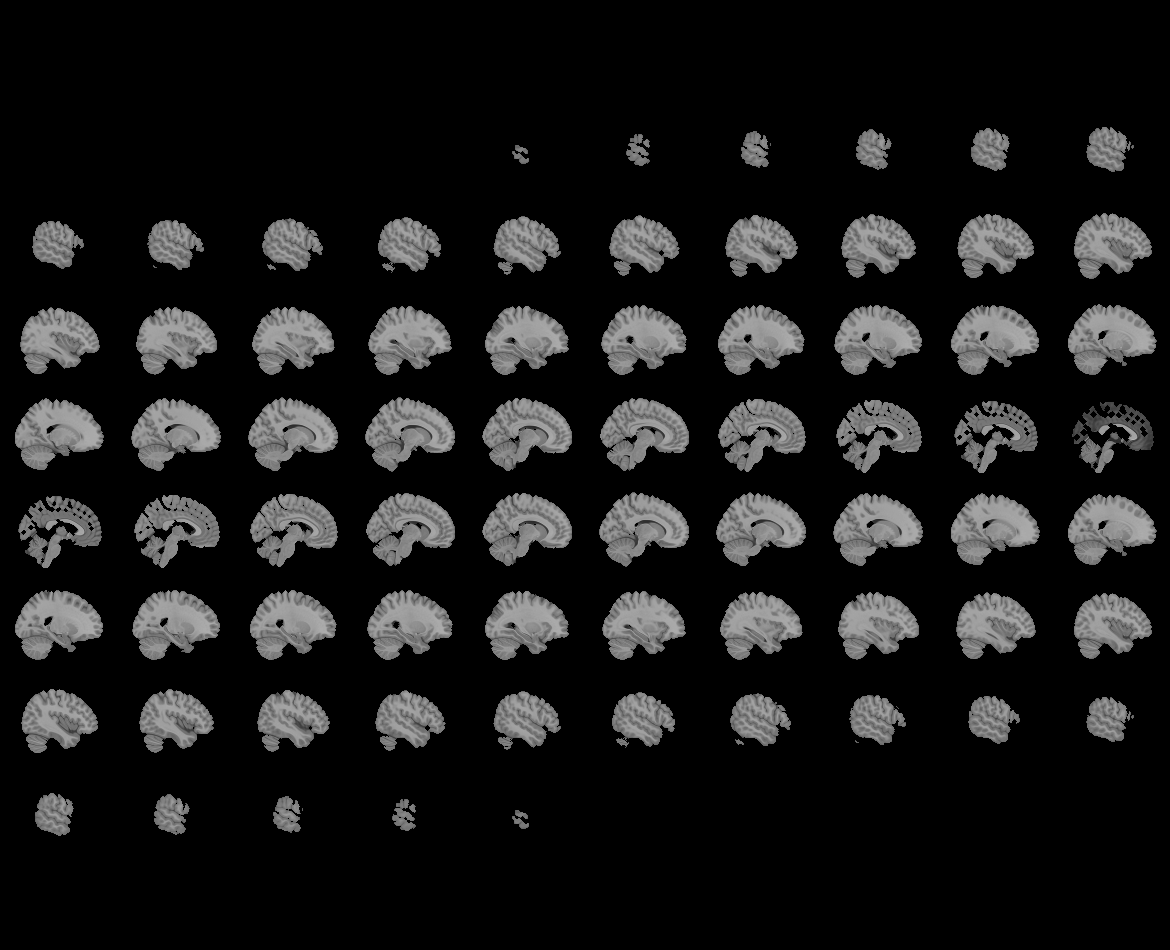
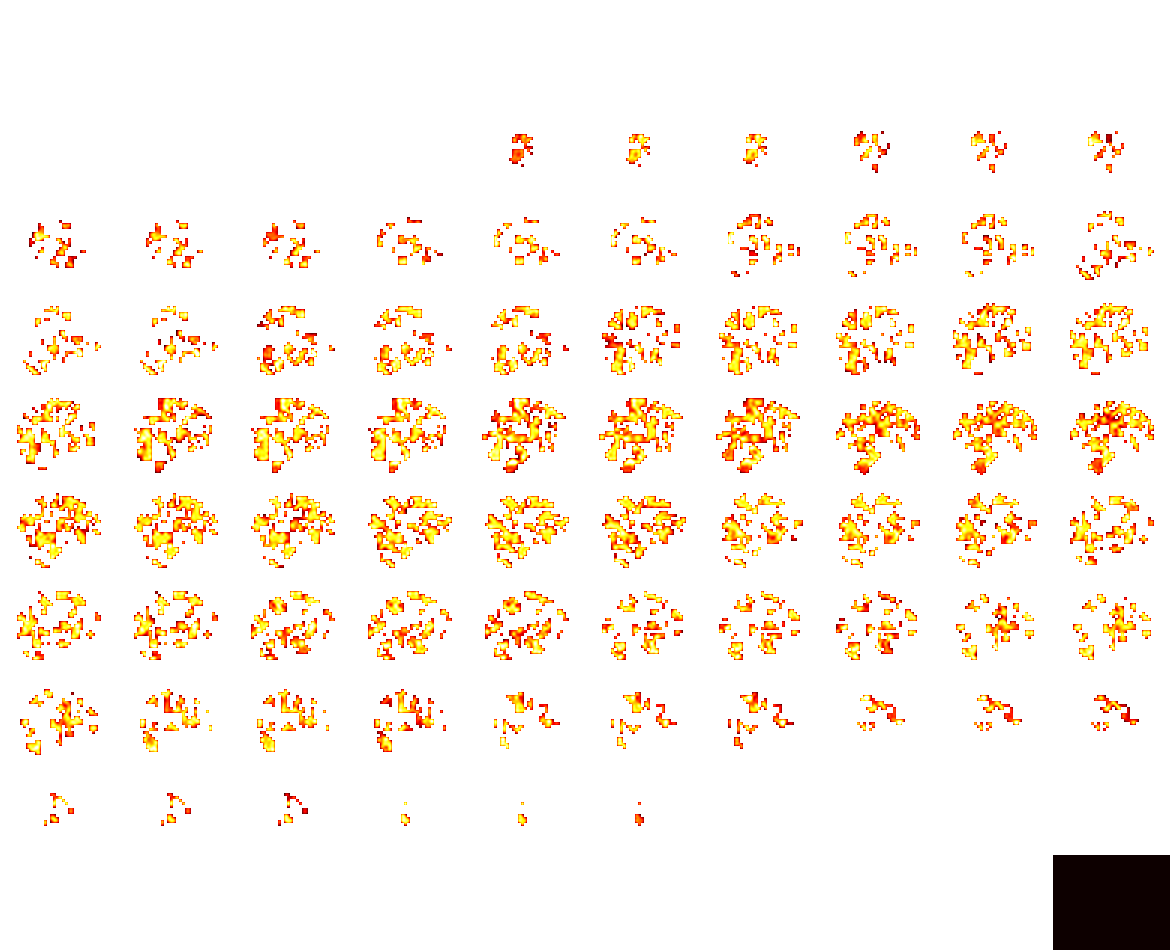

In [79]:
query = "autism spectrum disorder"
print('Encoding "{}"'.format(query))

result = encoder(query)

plotting.view_img(result["brain_map"], threshold=3.0).open_in_browser()

print("Similar words:")
print(result["similar_words"].head())
print("\nSimilar documents:")
print(result["similar_documents"].head())

print("\nmodel saved in {}".format(OUTPUT_DIRECTORY))

# Display in notebook
plotting.view_img(result["brain_map"], threshold=3.0)